## Imports

In [1]:
# Basics 
import numpy as np
import sys
import pickle
import os

# plotting 
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline 
from IPython.display import Image,display
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap

# Scipy 
import scipy 
import scipy.stats
from scipy.optimize import minimize
from scipy.stats import truncnorm
from scipy.optimize import linprog
from scipy.io import loadmat


In [2]:
np.random.seed(2)

In [3]:
# my code 
sys.path.append('./')
sys.path.append('../shared')

from nCVaR_Value_Iteration import nCVaR_VI
from pCVaR_Value_Iteration import pCVaR_VI
from scenarios import Agent, setup_params
from shared import induce_P

## Load MDP from Matlab

In [27]:
# load old matlab results, which have useful info for MDP
mat = loadmat('../simulation_results/2D_optimal_policy.mat')

# Unpack 
Ny = mat['Y_set_all'].shape[1]
Ns = mat['Y_set_all'].shape[0] # could subtract one here 
Na = 4
gamma = mat['dis'][0][0]
y_set = mat['Y_set_all'][0,:]
P = mat['P']
r = mat['r']
print(P.shape)
print("x,x',a")
y_set

(36, 36, 4)
x,x',a


array([0.  , 0.05, 0.1 , 0.3 , 0.6 , 1.  ])

In [28]:
testcase = 1
p,maze = setup_params(testcase) 
#agent = setup_agent_and_MDP(p,maze) 
maze[4,0]=1
maze[4,6]=1

agent = Agent({'num_states':Ns-1,
               'num_actions':Na,
               'start_states':[4],'r_params':p['r_params']},maze)

## Running NCVaR Value Iteration


In [29]:
# Run Policy Iteration
V0 = np.repeat((mat['V_Exp']/10),Ny,1);
P_full = np.repeat(P[:,:,np.newaxis,:],Ny,axis=2) # broadcast across Y dimension
r_x = r[:,0]

(Vd,Qd,Xid,Pid,V_storaged,Q_storaged,Xi_storaged,
 pointwise_errord,V_convergedd,multi_startsd) = nCVaR_VI(V0,
            Ns,Ny,Na,
            P_full,
            gamma,
            y_set,
            r_x, # only per state 
            check_pointwise_iters=3,
            pointwise_window=3,
            min_multi_starts=5,
            max_multi_starts=5,
            max_iters=100,
            verbose=False,
            converg_thresh = 1e-12,
            yi_pr=None,
            converg_type = 'full_eval')


--- 1224.2671959400177 seconds ---


### Save 

In [30]:
fname = '../simulation_results/2D_optimal_policy_nCVaR.npz'
fname

'../simulation_results/2D_optimal_policy_nCVaR.npz'

In [31]:
np.savez(fname,*[Vd,Xid,V_storaged,Qd,Q_storaged,Xid,Xi_storaged])

### Load 

In [15]:
# Load 
container = np.load(fname)
data = [container[key] for key in container]
Vd = data[0]
Xid = data[1]
V_storaged=data[2]
Qd = data[3]
Q_storaged = data[4]
Xid = data[5]
Xi_storaged = data[6]

### Convergence 

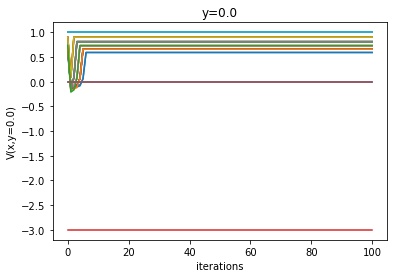

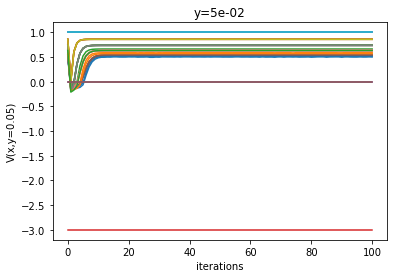

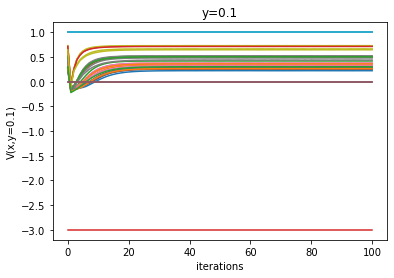

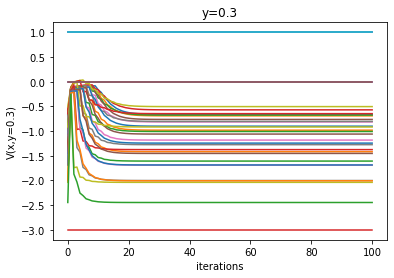

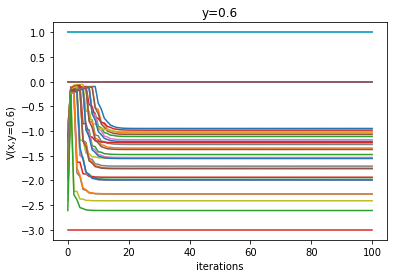

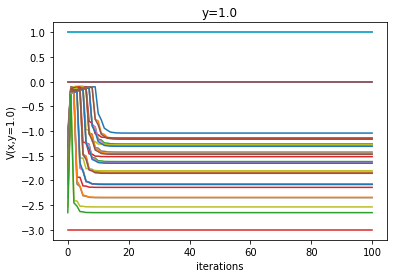

In [16]:
for y in range(6): #[1,5,11,15,18,20]:
    plt.figure()
    plt.title('y='+str(np.round(y_set[y],2)))
    plt.plot(V_storaged[:,:,y]);
    plt.xlabel('iterations')
    plt.ylabel('V(x,y='+str(np.round(y_set[y],2))+')')

## Running pCVaR Value Iteration


In [17]:
# Run Policy Iteration
V0 = np.repeat((mat['V_Exp']/10),Ny,1);
P_full = np.repeat(P[:,:,np.newaxis,:],Ny,axis=2) # broadcast across Y dimension
r_x = r[:,0]

(V,Q,Xi,Pi,V_storage,Q_storage,Xi_storage,
 pointwise_error,V_converged,multi_starts) = pCVaR_VI(V0,
                                                    Ns,Ny,Na,
                                                    P_full,
                                                    gamma,
                                                    y_set,
                                                    r_x, # only per state 
                                                    check_pointwise_iters=3,
                                                    pointwise_window=3,
                                                    min_multi_starts=2,
                                                    max_multi_starts=5,
                                                    max_iters=100,
                                                    verbose=False,
                                                    converg_thresh = 0.001,
                                                    yi_pr=None,
                                                    converg_type = 'full_eval')


/kyb/agpd/cgagne/miniconda3/envs/env_cvar/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


--- 1783.8604216575623 seconds ---


### Save 

In [22]:
fname = '../simulation_results/2D_optimal_policy_pCVaR.npz'
fname

'../simulation_results/2D_optimal_policy_pCVaR.npz'

In [23]:
np.savez(fname,*[V,Xi,V_storage,Q,Q_storage,Xi,Xi_storage])

### Load 

In [24]:
# Load 
container = np.load(fname)
data = [container[key] for key in container]
V = data[0]
Xi = data[1]
V_storage=data[2]
Q = data[3]
Q_storage = data[4]
Xi = data[5]
Xi_storage = data[6]

### Convergence 

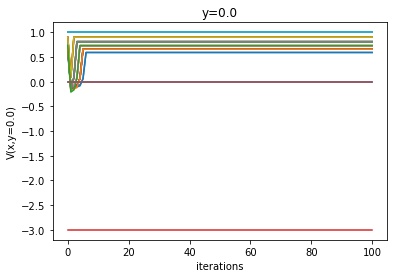

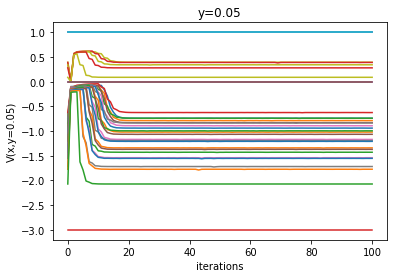

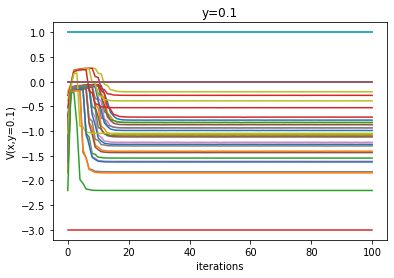

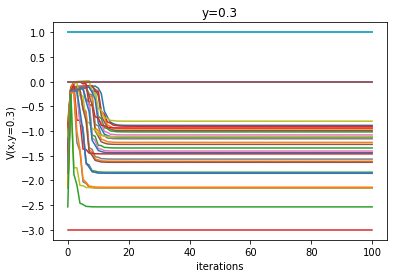

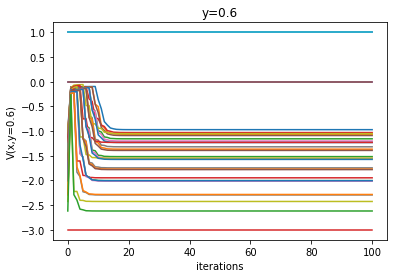

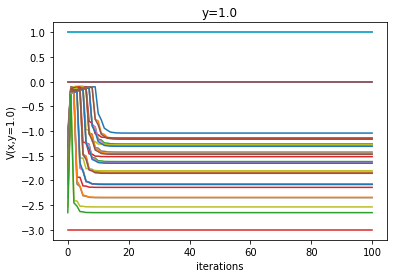

In [25]:
for y in range(6): #[1,5,11,15,18,20]:
    plt.figure()
    plt.title('y='+str(np.round(y_set[y],2)))
    plt.plot(V_storage[:,:,y]);
    plt.xlabel('iterations')
    plt.ylabel('V(x,y='+str(np.round(y_set[y],2))+')')